In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import les5

import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)

We load up the bits from a recording done on 2020-04-02 and synchronize frames using those bits.

In [2]:
bits = les5.generate_bits_from_symbolsf32(np.fromfile('symbols_20200402.f32', dtype = 'float32'))
frames = np.array(list(les5.generate_frames(bits)))
frames.shape

(7088, 256)

We are going to collect frames in groups. A group is a set of 16 formats, each of which is composed of 4 frames. The beginning of a group can be detected because the first frame 0 in that group (i.e., frame 0 in format 0) has a special pattern in word 7. We detect that pattern.

In [3]:
frame_0_format_0 = (les5.frame_number(frames) == 0) & \
    np.all(frames[:,7*8:8*8] == np.array([1,1,1,1,0,1,0,0], dtype = 'uint8'), axis = 1)

We see that the pattern occurs every 64 frames almost every time, as expected. Occasions when there are less frames correspond to missing frames. We extract only the groups which are complete (i.e., formed by 64 frames).

In [4]:
loc = np.where(frame_0_format_0)[0]
np.diff(loc)

array([48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 56, 64, 64, 64, 64, 64,
       64, 64, 59, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 61, 64, 64, 64, 64, 64,
       64, 54, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
       64, 62, 64, 64, 64, 64, 63, 64, 64])

We classify frames by group number, format number in gruop, frame number in format, and bit in frame.

In [5]:
group_starts = loc[:-1][np.diff(loc) == 64]
groups = np.empty((group_starts.size, 16, 4, 256), dtype = 'uint8')
for j,start in enumerate(group_starts):
    groups[j] = frames[start:start+64].reshape((16, 4, 256))

groups.shape

(104, 16, 4, 256)

Word 7 in frame 2 is important for the RFI experiment telemetry, as it seems to contain the frequency that the receiver is currently sweeping. We plot below the values of this word in each group. As we will see more clearly below, the value of this word makes a full downsweep every 4 groups. Note that, according to the [description of the LES-5 RFI experiment](https://www.semanticscholar.org/paper/The-Results-of-the-LES-5-and-LES-6-RFI-Experiments-Ward-Sicotte/7d6162283e3b14c1a837cc5b4a1cd4fe643ce0d3), a frequency sweep of the RFI receiver corresponds exactly to 4 groups: a sweep of 256 measurement frequencies at 1 frame (2.56 seconds) per measurement, or equivalently, 4 groups times 16 formats per group times 4 frames per format.

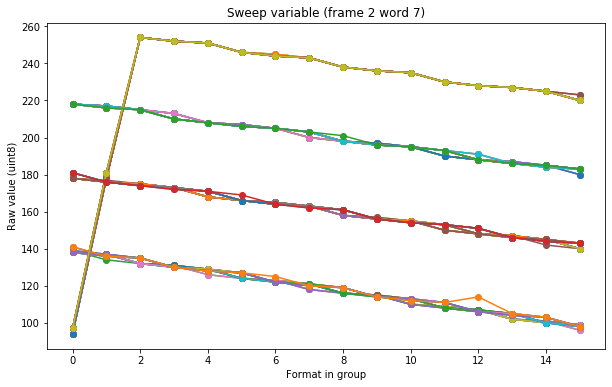

In [6]:
sweep_per_group = np.packbits(groups[:,:,2,7*8:8*8], axis = -1).reshape((-1,16))

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(sweep_per_group.transpose(), 'o-')
plt.title('Sweep variable (frame 2 word 7)')
plt.ylabel('Raw value (uint8)')
plt.xlabel('Format in group');

As we see below, if we collect in terms of four groups, frame 2 word 7 does a full sweep. We only plot 12 of these. 11 of them line up completely, while the next one jumps in phase probably due to a lost group.

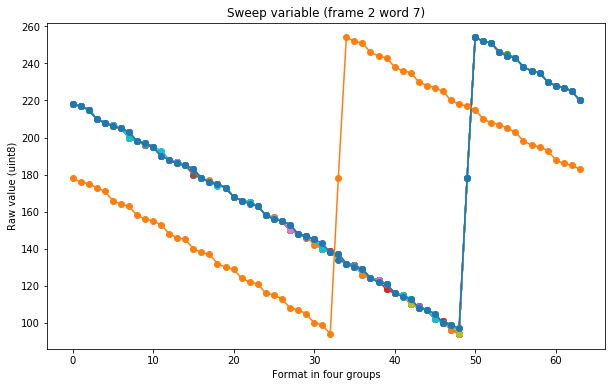

In [7]:
sweep_per_four_groups = sweep_per_group[:sweep_per_group.size//4*4].reshape((-1,16*4))

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(sweep_per_four_groups[:12].transpose(), 'o-')
plt.title('Sweep variable (frame 2 word 7)')
plt.ylabel('Raw value (uint8)')
plt.xlabel('Format in four groups');

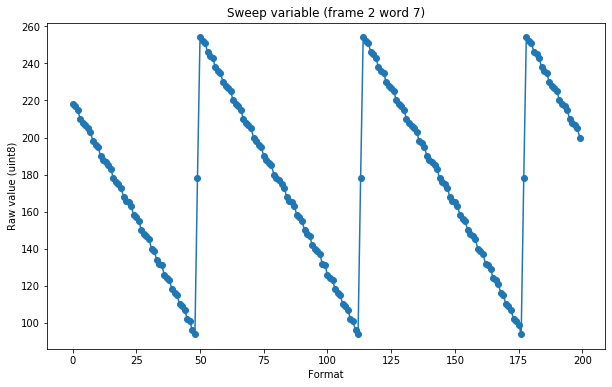

In [8]:
sweep = sweep_per_group.ravel().astype('float')

plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(sweep[:200], 'o-')
plt.title('Sweep variable (frame 2 word 7)')
plt.ylabel('Raw value (uint8)')
plt.xlabel('Format');

In each format, there is only one "sweep variable" indicating the frequency to which the RFI receiver is tuned. However, there are four different RFI measurments (one in each of the frmaes in the format) corresponding to four different frequency steps. Thus, we do some kind of interpolation to assign a value of the sweep variable to each of the four measurments in the format.

To simplify things, the value of the sweep variable in frame 2 is assigned to the RFI measurement in frame 0, while the value of the sweep variable corresponding to the measurements in frames 1, 2, 3 is interpolated with the value of the sweep variable in frame 2 of the current format and the value of the sweep variable in frame 2 in the next format.

At some point, the sweep ends and the sweep variable sweeps back, this can actually be seen in one of the values in frame 2, where the sweep variable can be seen mid-range, sweeping back.

To handle sweep backs, we extrapolate instead of interpolate for the last format in the sweep and put `nan`'s for the mid-range sweep back format, so the sweeps are conveniently split and then we can plot each sweep separately.

In [9]:
sweep1 = 0.25*sweep[1:] + 0.75*sweep[:-1]
sweep2 = 0.5*sweep[1:] + 0.5*sweep[:-1]
sweep3 = 0.75*sweep[1:] + 0.25*sweep[:-1]

idx_jump = np.where(sweep[1:] - sweep[:-1] > 10)[0]
sweep1[idx_jump] = -0.25*sweep[:-1][idx_jump-1] + 1.25*sweep[:-1][idx_jump]
sweep2[idx_jump] = -0.5*sweep[:-1][idx_jump-1] + 1.5*sweep[:-1][idx_jump]
sweep3[idx_jump] = -0.75*sweep[:-1][idx_jump-1] + 1.75*sweep[:-1][idx_jump]

sweep_total = np.stack((sweep[:-1], sweep1, sweep2, sweep3), axis = -1).ravel()
sweep_total[:-1][np.abs(sweep_total[1:]-sweep_total[:-1]) > 12] = np.nan

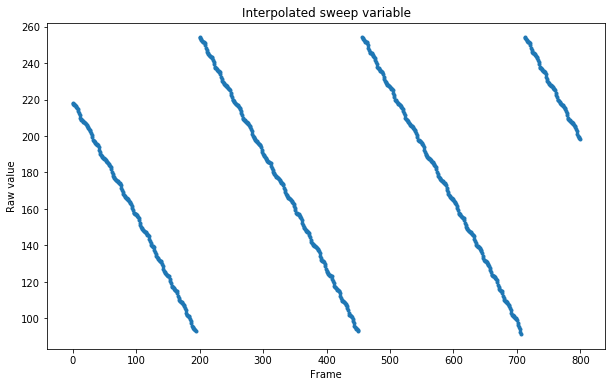

In [10]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(sweep_total[:800], '.-')
plt.title('Interpolated sweep variable')
plt.ylabel('Raw value')
plt.xlabel('Frame');

The measurements of the RFI experiment are contained in words 21 and 26 in each of the four frames comprising a format. Word 21 contains the average power and word 26 contains the peak-to-average power.

Below we plot the values of these measurements against the value of the interpolated sweep variable. We do a different plot per sweep.

We see that sweeps with even sweep # have a flat response. My interpretation is that these are the sweeps when the RFI experiment is tuned to a fixed frequency and used as a command receiver.

Sweeps # 5, 13 and 21 (i.e., every 8 sweeps) have spikes. My interpretation is that these are the sweeps when the frequency markers are enabled. In fact, regarding average power, there are 6 groups of 3 spikes in the center of the spectrum, as described by Figure 64 in the [RFI experiment document](https://www.semanticscholar.org/paper/The-Results-of-the-LES-5-and-LES-6-RFI-Experiments-Ward-Sicotte/7d6162283e3b14c1a837cc5b4a1cd4fe643ce0d3), and two peaks at the sides of the spectrum, again matching the document. There are additional smaller spikes which I can't explain yet. Perhaps they are simply intermodulation.

Regarding the peak to average power, the typical M pattern described in the experiment results as a CW tone is sweeped is seen (albeit the raw values are inverted): this is caused because the peak-to-average has a moderate value when there is only noise, a very high value as the CW tone moves inside the 600kHz passband where peak power is measured by not yet inside the 120kHz passband where average power is measured, and a value close to 0dB once the CW tone is both inside the passbands of average power measurement and peak power measurements.

The remaining sweeps (i.e., odd sweeps that don't contain markers) show a slight variation of power of average power across the spectrum. My interpretation is that these are the sweeps of the RFI experiment is sweeping without markers. I think that there are no signals visible because of deterioration in the antennas or receive chain (or maybe gain not set appropriately), so the receiver is rather "deaf".

There are some sweeps where some part of the sweep is missing, and interpolation goes much faster than it should. These are probably due to a lost group in the sweep.

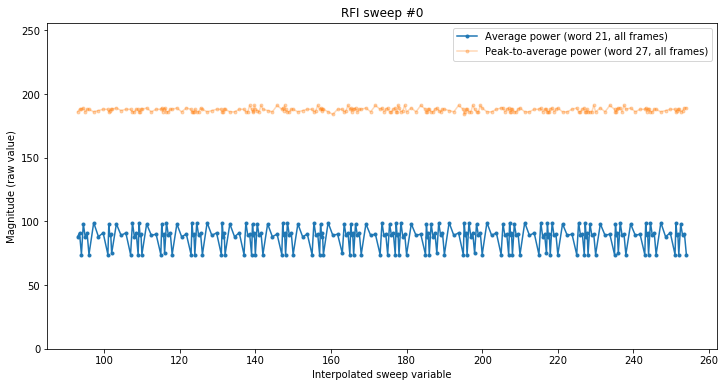

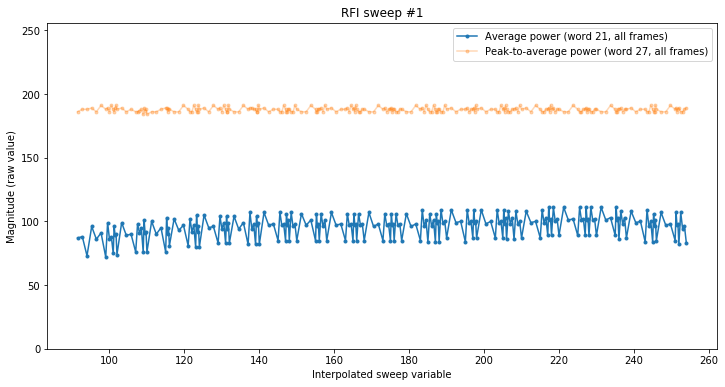

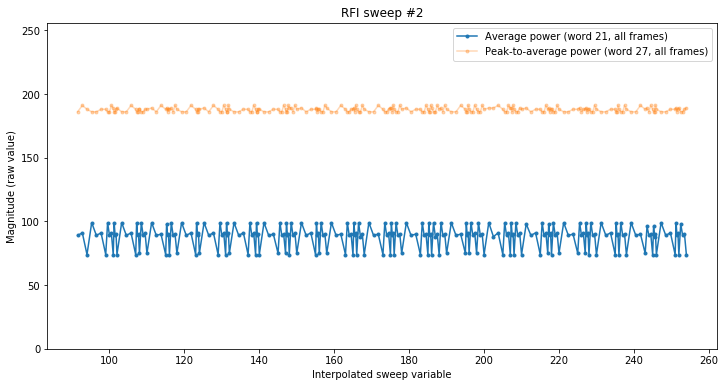

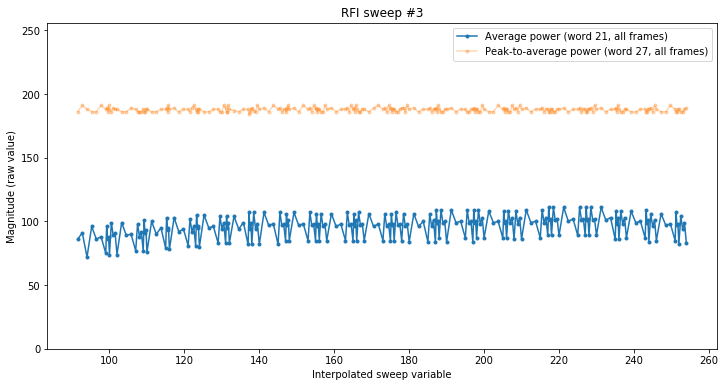

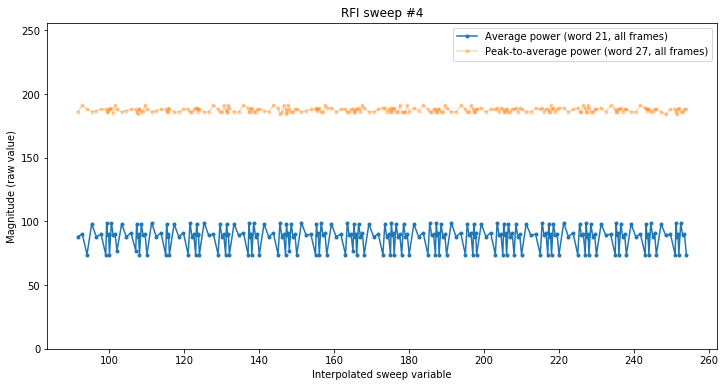

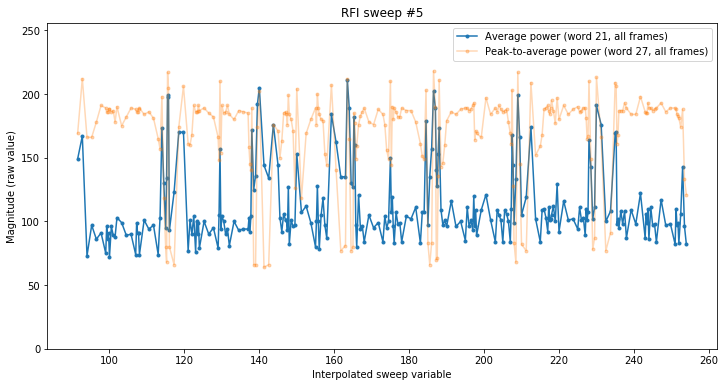

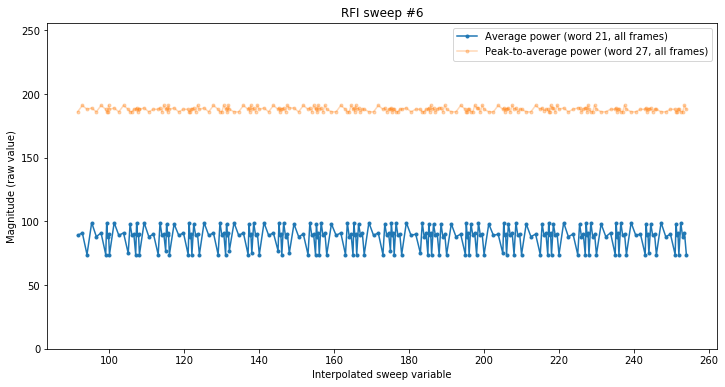

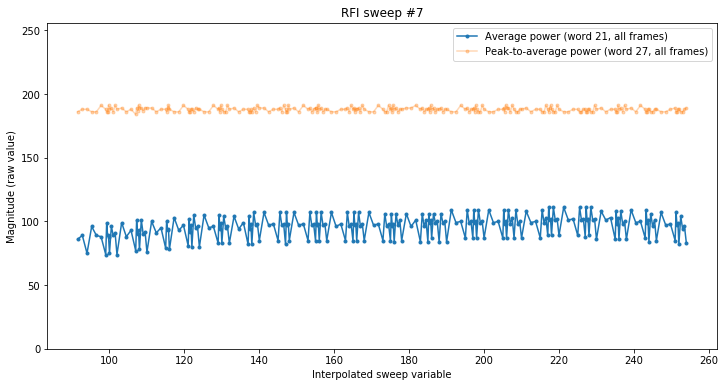

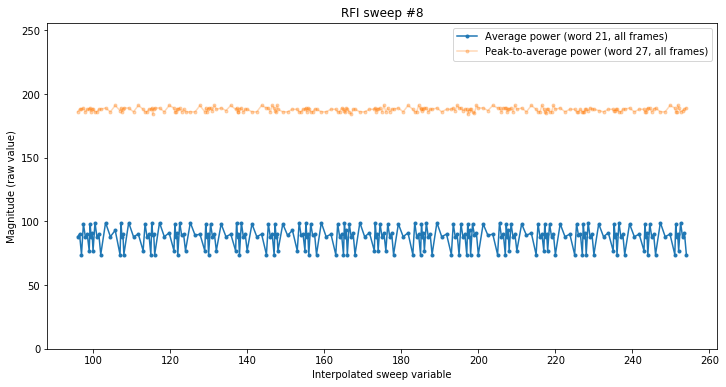

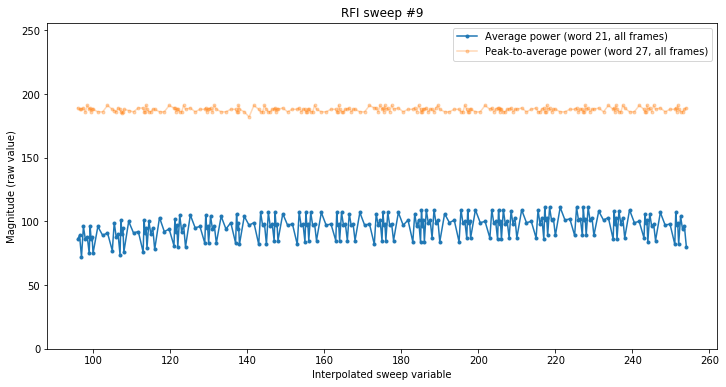

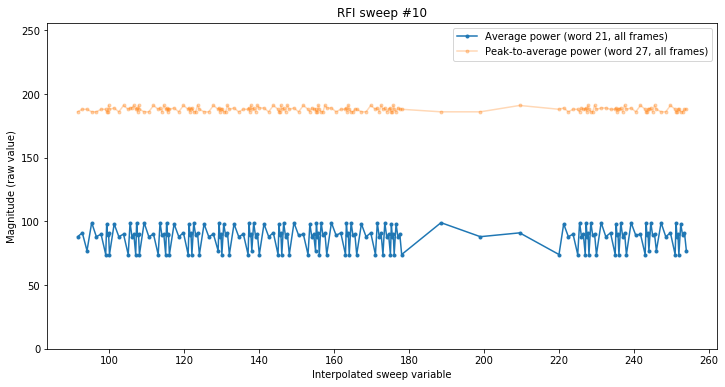

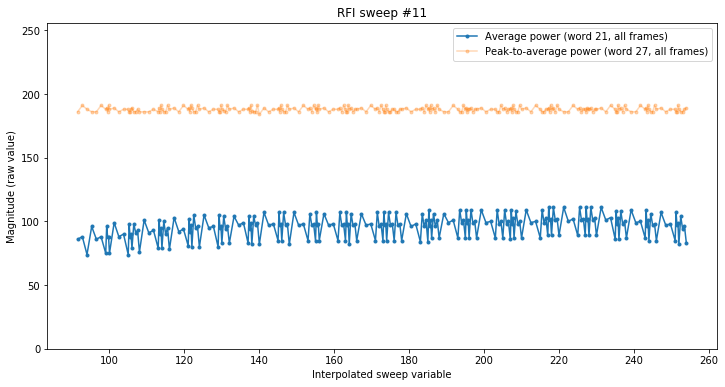

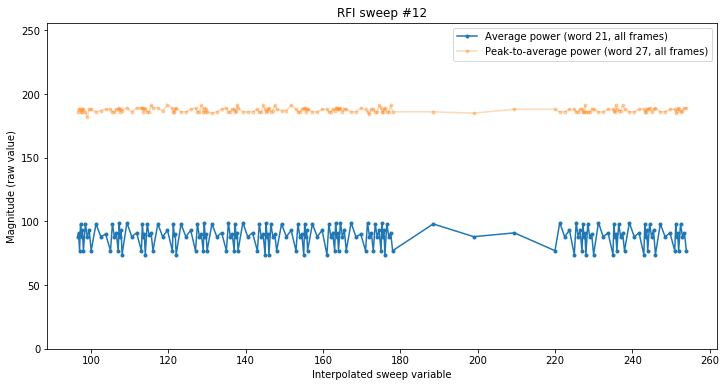

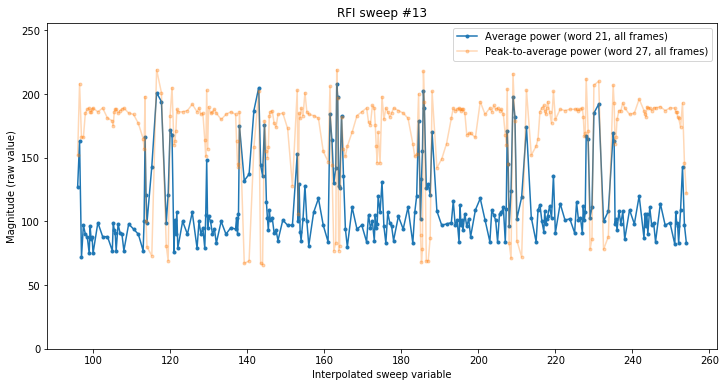

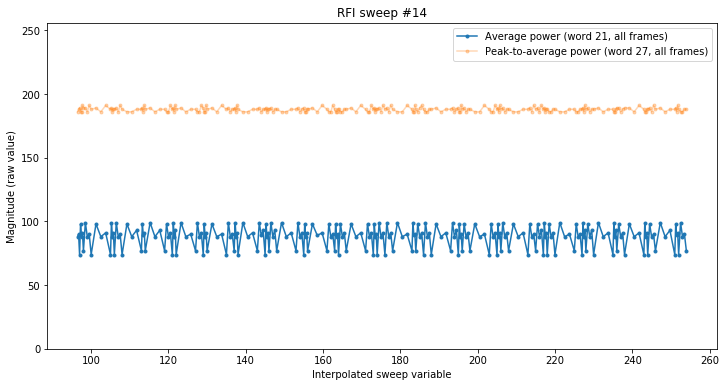

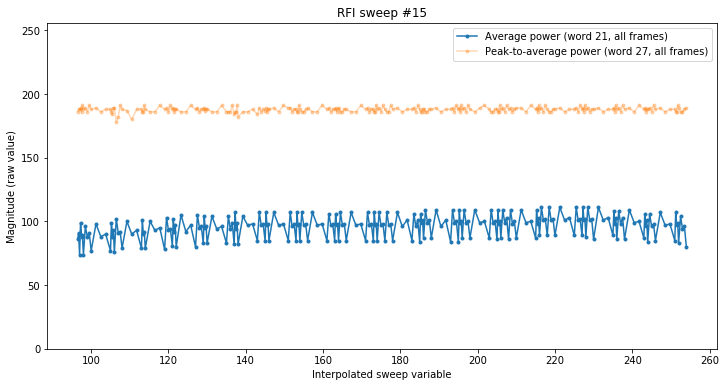

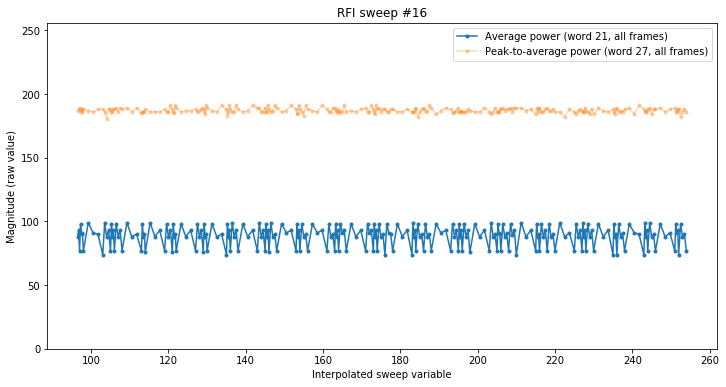

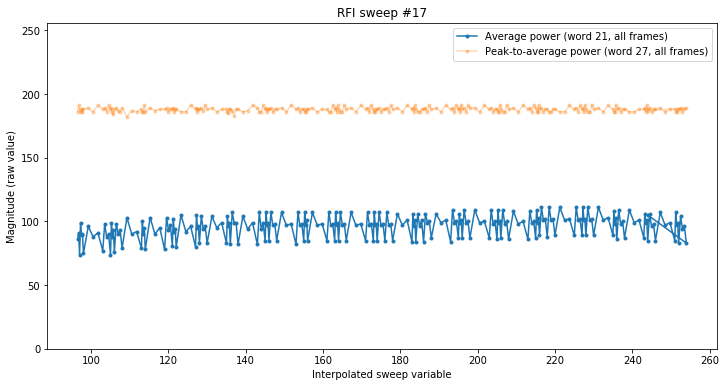

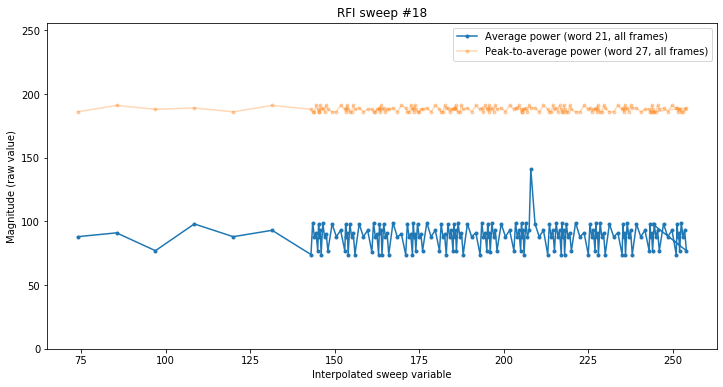

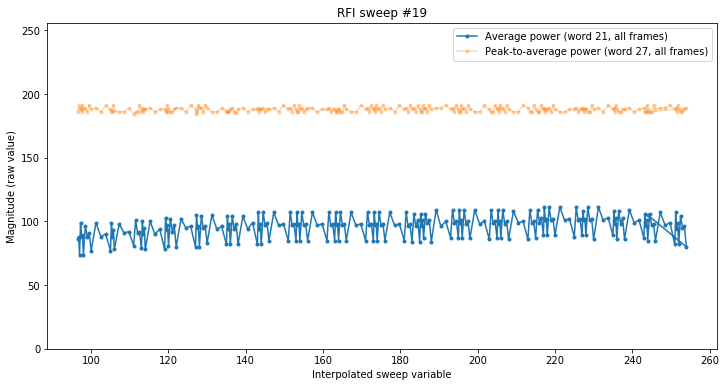

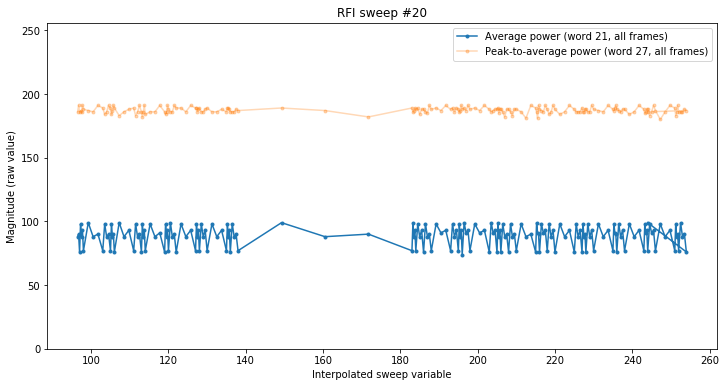

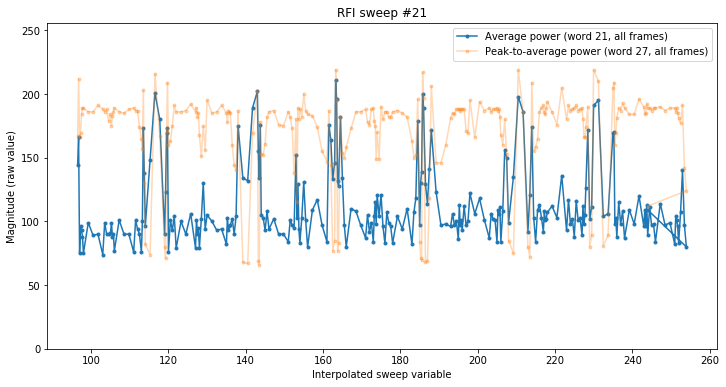

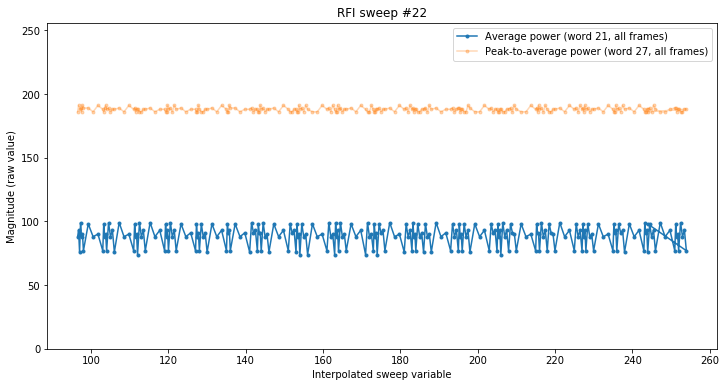

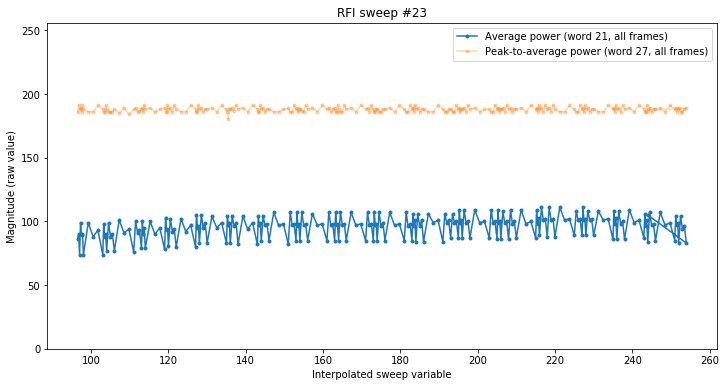

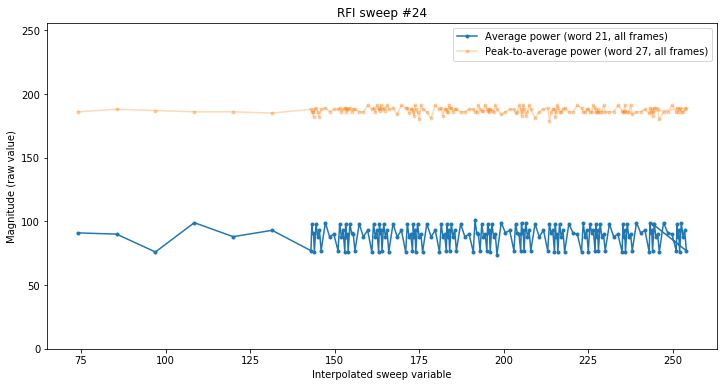

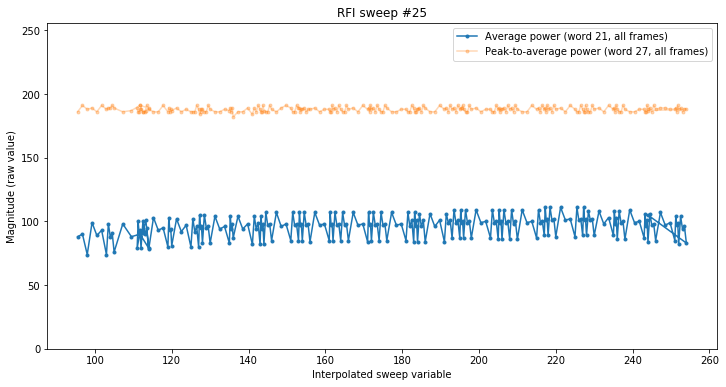

In [11]:
word_A = 21
word_B = 26

sw_nan = np.where(np.isnan(sweep_total))[0]
sweep_num = 0
for a,b in zip(sw_nan[:-1], sw_nan[1:]):
    if np.sum(~np.isnan(sweep_total[a:b])) >= 2:
        plt.figure(figsize = (12,6), facecolor = 'w')
        plt.plot(sweep_total[a:b],
             np.packbits(groups[:,:,:,word_A*8:(word_A+1)*8], axis = -1).ravel()[a:b], '.-')
        plt.plot(sweep_total[a:b],
             np.packbits(groups[:,:,:,word_B*8:(word_B+1)*8], axis = -1).ravel()[a:b], '.-', alpha = 0.3)
        plt.ylim(0,256)
        plt.legend(['Average power (word 21, all frames)', 'Peak-to-average power (word 27, all frames)'])
        plt.xlabel('Interpolated sweep variable')
        plt.ylabel('Magnitude (raw value)')
        plt.title(f'RFI sweep #{sweep_num}')
        sweep_num += 1

Now we plot only sweeps corresponding to the crystal markers, to compare them and check the accuracy/repeatability of each sweep. We can see that the tones don't line up very well.

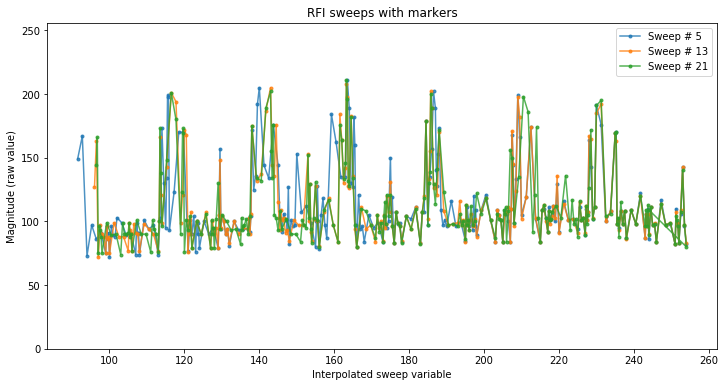

In [12]:
sweep_num = 0
plt.figure(figsize = (12,6), facecolor = 'w')
for a,b in zip(sw_nan[:-1], sw_nan[1:]):
    if np.sum(~np.isnan(sweep_total[a:b])) >= 2:
        if sweep_num % 8 == 5:
            plt.plot(sweep_total[a:b],
                 np.packbits(groups[:,:,:,word_A*8:(word_A+1)*8], axis = -1).ravel()[a:b], '.-', alpha = 0.8,
                     label = f'Sweep # {sweep_num}')
            #plt.plot(sweep_total[a:b],
            #     np.packbits(groups[:,:,:,word_B*8:(word_B+1)*8], axis = -1).ravel()[a:b], '.-', alpha = 0.3)
        sweep_num += 1
plt.ylim(0,256)
plt.legend()
plt.xlabel('Interpolated sweep variable')
plt.ylabel('Magnitude (raw value)')
plt.title(f'RFI sweeps with markers');

If instead of sweeping against the value of the interpolated sweep variable we ignore this sweep variable and plot against measurement (frame) in sweep, we obtain a much more repeatable behaviour. This questions the accuracy of the sweep variable.

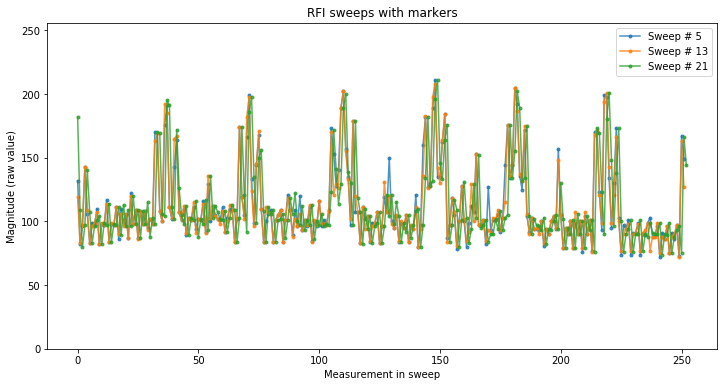

In [13]:
sweep_num = 0
plt.figure(figsize = (12,6), facecolor = 'w')
for a,b in zip(sw_nan[:-1], sw_nan[1:]):
    if np.sum(~np.isnan(sweep_total[a:b])) >= 2:
        if sweep_num % 8 == 5:
            plt.plot(
                 np.packbits(groups[:,:,:,word_A*8:(word_A+1)*8], axis = -1).ravel()[a:b], '.-', alpha = 0.8,
                     label = f'Sweep # {sweep_num}')
            #plt.plot(sweep_total[a:b],
            #     np.packbits(groups[:,:,:,word_B*8:(word_B+1)*8], axis = -1).ravel()[a:b], '.-', alpha = 0.3)
        sweep_num += 1
plt.ylim(0,256)
plt.legend()
plt.xlabel('Measurement in sweep')
plt.ylabel('Magnitude (raw value)')
plt.title(f'RFI sweeps with markers');

The plot below shows that the sweep variable has important differences in each sweep.

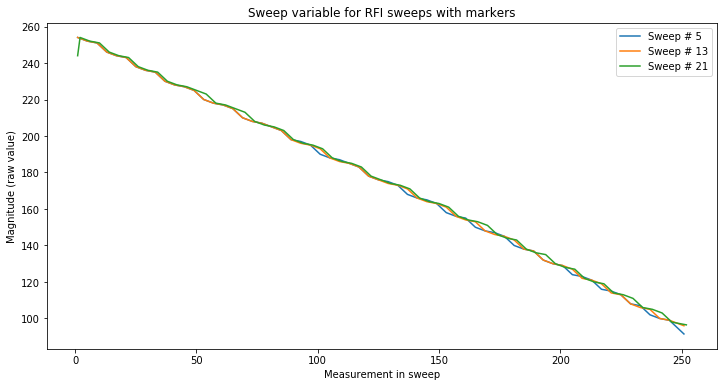

In [14]:
sweep_num = 0
plt.figure(figsize = (12,6), facecolor = 'w')
for a,b in zip(sw_nan[:-1], sw_nan[1:]):
    if np.sum(~np.isnan(sweep_total[a:b])) >= 2:
        if sweep_num % 8 == 5:
            plt.plot(sweep_total[a:b], label = f'Sweep # {sweep_num}')
        sweep_num += 1
plt.legend()
plt.xlabel('Measurement in sweep')
plt.ylabel('Magnitude (raw value)')
plt.title(f'Sweep variable for RFI sweeps with markers');